In [34]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
#export
from exp.nb_04 import *

## Initial setup

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7013)

In [36]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
n_hidden,batch_size = 50,512
n_out = y_train.max().item()+1
loss_func = F.cross_entropy

In [37]:
data = DataBunch(*get_dls(train_ds, valid_ds, batch_size), n_out)

In [38]:
#export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [39]:
# instantiate a learner object
learn = create_learner(get_model, loss_func, data)
# instantiate a runner object
run = Runner([AvgStatsCallback([accuracy])])
# run the training loop
run.fit(learn, n_epochs=3)

train: [0.68187890625, tensor(0.8011)]
valid: [0.3059528564453125, tensor(0.9135)]
train: [0.29763431640625, tensor(0.9142)]
valid: [0.2559523193359375, tensor(0.9243)]
train: [0.240153515625, tensor(0.9307)]
valid: [0.219201806640625, tensor(0.9367)]


In [42]:
# instantiate a learner object
learn = create_learner(partial(get_model, learning_rate=0.3), loss_func, data)
# instantiate a runner object
run = Runner([AvgStatsCallback([accuracy])])
# run the training loop for 3 epochs
run.fit(learn, n_epochs=3)

train: [0.767102734375, tensor(0.7992)]
valid: [0.35289853515625, tensor(0.9019)]
train: [0.3472712890625, tensor(0.9001)]
valid: [0.28880732421875, tensor(0.9182)]
train: [0.29487681640625, tensor(0.9148)]
valid: [0.260827685546875, tensor(0.9260)]


In [56]:
#export
def get_model_func(learning_rate=0.5): 
    return partial(get_model, learning_rate=learning_rate)

## Annealing

We define two new callbacks: the Recorder to save track of the loss and our scheduled learning rate, and a ParamScheduler that can schedule any hyperparameter as long as it's registered in the state_dict of the optimizer. 

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7202)

In [282]:
#export
class Recorder(Callback):
    def begin_fit(self): 
        self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): self.pname,self.sched_func = pname,sched_func

    def set_param(self):
        for pg in self.opt.param_groups:
            # ?????
            # n_epochs is always 0.0
            # pg[self.pname] = self.sched_func(self.n_epochs,self.epoch)
            # print(self.epoch, self.n_epochs)
            # pg[self.pname] = self.sched_func(self.frac_epoch/(self.epoch+1))
            pg[self.pname] = self.sched_func(self.frac_epoch)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

Let's start with a simple linear schedule going from start to end. It returns a function that takes a `pos` argument (going from 0 to 1) such that this function goes from `start` (at `pos=0`) to `end` (at `pos=1`) in a linear fashion.

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7431)

In [283]:
def sched_lin(start, end):
    def _inner(start, end, pos): 
        return start + pos*(end-start)
    return partial(_inner, start, end)

We can refactor this with a decorator.

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7526)

In [284]:
#export
def annealer(f):
    def _inner(start, end): 
        return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): 
    return start + pos*(end-start)

In [285]:
# shift-tab works too, in Jupyter!
# sched_lin()

In [286]:
f = sched_lin(1,2)
f(0.3)

1.3

And here are other scheduler functions:

In [287]:
#export
@annealer
def sched_cos(start, end, pos): 
    return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  
    return start
@annealer
def sched_exp(start, end, pos): 
    return start * (end/start) ** pos

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

[Jump_to lesson 9 video](https://course.fast.ai/videos/?lesson=9&t=7730)

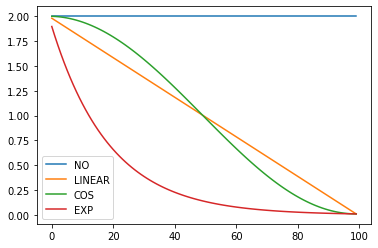

In [288]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In practice, we'll often want to combine different schedulers, the following function does that: it uses `scheds[i]` for `pcts[i]` of the training.

In [289]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

Here is an example: use 30% of the budget to go from 0.3 to 0.6 following a cosine, then the last 70% of the budget to go from 0.6 to 0.2, still following a cosine.

In [290]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

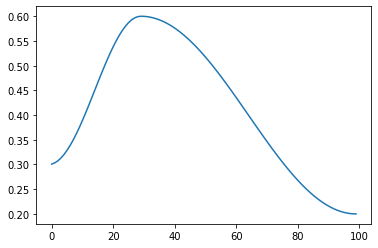

In [291]:
plt.plot(a, [sched(o) for o in p])

We can use it for training quite easily...

In [292]:
callback_funcs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'learning_rate', sched)]

In [293]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(callback_funcs=callback_funcs)

In [294]:
# scheduling not working yet
run.fit(learn, n_epochs = 3)

train: [0.771172109375, tensor(0.7990)]
valid: [0.353820849609375, tensor(0.8985)]
train: [0.34577609375, tensor(0.9009)]
valid: [0.285176953125, tensor(0.9184)]
train: [0.29202923828125, tensor(0.9170)]
valid: [0.2558614990234375, tensor(0.9290)]


... then check with our recorder if the learning rate followed the right schedule.

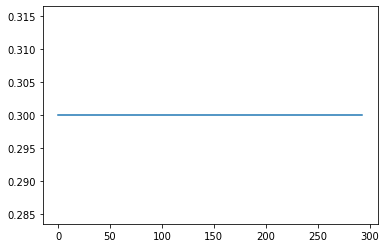

In [295]:
run.recorder.plot_lr()

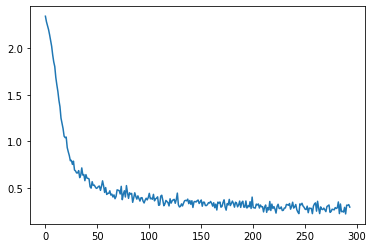

In [296]:
run.recorder.plot_loss()

## Export

In [297]:
!python notebook2script.py 05_anneal_jcat.ipynb

Converted 05_anneal_jcat.ipynb to exp\nb_05.py
